**Implémentation recurrent reinforcement learning**


*Imporation librairies utiles*

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

*Modélisation*

Comme expliqué dans le rapport , la fonction qui permet de déterminer  les  positions, au temps $t$ est: $F_{t}=\tanh(θ^{T} x_{t})$

Cette fonction  génère une valeur comprise entre -1 et 1, qui nous indiquera quel pourcentage on devra acheter l'actif. $θ$ represente l'ensemble  des paramètres à optimiser en utilisant la montée de gradient, et $x_{t}$ sera l'input au temps $t$ ; 
$x_{t}= [1, r_{t - M}, … , r_t, F_{t - 1}]$

où $r_{t}$ est le changement de valeur entre l'actif au temps $t$ et $t-1$, et $M$ est le nombre d'input de nos séries temporelles. Cela signifie qu'à chaque étape temporelle, le modèle sera alimenté par sa dernière position et une série de changements de prix historiques qu'il pourra utiliser pour calculer sa prochaine position.

In [95]:
def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    y = np.zeros(T)
    F=np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [F[t - 1]]])
        y[t] = np.tanh(np.dot(theta, xt))
        
        if y[t]>0:
            F[t]=1
        elif y[t]==0:
            F[t]=F[t-1]
        else:
            F[t]=-1
    return y,F

La fonction de récompense $R$ est calculée à chaque étape temporelle en utilisant la formule suivante :

$R_{t}$=$μ[F_{t-1}r_{t}- δ|F_{t}-F_{t-1}|]$

* $μ$ : Le montant du capital à investir.
* $r_{t}$ : Le taux de rendement géométrique au temps $t$.
* $δ$ : Le coût de transaction en pourcentage lié au quota du portefeuille à échanger.

In [96]:
def rewards(F, x, delta,mu):
    T = len(x)
    rets =mu* (F[0:T - 1] * x[1:T] - delta * np.abs(F[1:T] - F[0:T - 1]))
    return np.concatenate([[0], rets])

Fonction  `rrwds` qui correspond à la réciproque de la mesure de symétrie directionnelle pondérée des rendements.
Ce ratio est donné à chaque temps $t$ par le rapport entre les récompenses cumulées positives et les récompenses cumulées négatives.

In [97]:
def rrwds(A_last,B_last,R,eta):

    if R>0:
        A=eta*R+(1-eta)*A_last
        B=B_last
    else:
        A=A_last
        B=-eta*R+(1-eta)*B_last

    return A/B,A,B

Fonction pour le drawdown

In [98]:
def drawdown(trading_off,t,x,theta):
    x_trading_off=x[t:trading_off+t]
    F,Fsign = positions(x_trading_off, theta)
    R=rewards(F,x_trading_off,delta,mu)

    l_drawdown=[]
    for i in range(t,trading_off):
        CR=sum(R[:i])
        if (Fsign[i]*Fsign[i-1]<0) and (R[i]<0) and (CR<0):
            l_drawdown.append(R[i])
    
    if l_drawdown:
        return min(l_drawdown)
    else:
        return 0 

Fonction pour le calcul du gradient ascend

Pour réaliser le gradient ascend ,il faut calculer la dérivée de la fonction rrwds par rapport à $θ$ ($\frac{dU_{t}}{dθ}$).

En utilisant la règle de dérivation en chaîne , on a :
$\frac{dU_{t}}{dθ}=\frac{dU_{t}}{dR_{t}}(\frac{dR_{t}}{dF_{t}}\frac{dF_{t}}{dθ}+\frac{dR_{t}}{dF_{t-1}}\frac{dF_{t-1}}{dθ})$

In [99]:
def gradient(x, theta, delta,mu,eta, trading_off):
    T = len(x)
    M = len(theta) - 2

    F,Fpos = positions(x, theta)
    R=rewards(F,x,delta,mu)
    A=np.zeros(T)
    B=np.zeros(T)
    I=np.zeros(T)

    for t in range(M,T):
        I[t],A[t],B[t] = rrwds(A[t-1],B[t-1],R[t],eta)
  
    grad = np.zeros(M + 2) 
    dFpdtheta = np.zeros(M + 2) 
    
    CRT=sum(R)
    for t in range(M+trading_off+1, T):
        if R[t]>0:
            dUdR=1/B[t-1] 
        else:
            dUdR=A[t-1]*B[t-1]/B[t-1]**3
        
        dRdF=-mu*delta*np.sign(F[t]-F[t-1])
        dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
        xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
        dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

        dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, CRT

Fonction pour le calcul du gradient ascend en considérant le phénomène de drawdown.

In [100]:
def gradient_drawdown(x, theta, delta,mu,eta,trading_off,trading_on):
    T = len(x)
    M = len(theta) - 2

    t_current=0
    while t_current+trading_off+trading_on<T:
        mu_drawdown=drawdown(trading_off,t_current,x,theta)
        mu_update=mu+mu_drawdown

        F,Fpos = positions(x, theta)
        R=rewards(F,x,delta,mu_update)
        A=np.zeros(T)
        B=np.zeros(T)
        I=np.zeros(T)

        for t in range(M,T):
            I[t],A[t],B[t] = rrwds(A[t-1],B[t-1],R[t],eta)
      
        grad = np.zeros(M + 2) 
        dFpdtheta = np.zeros(M + 2) 
        
        CRT=sum(R)

        for t in range(M+t_current+trading_off+1,t_current+trading_off+trading_on):
            if R[t]>0:
                dUdR=1/B[t-1]
            else:
                dUdR=A[t-1]*B[t-1]/B[t-1]**3
            
            dRdF=-mu*delta*np.sign(F[t]-F[t-1])
            dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
            xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
            dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

            dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

        t_current+=trading_on

    if M+t_current<T:
        for t in range(M+t_current+1,T):
            if R[t]>0:
                dUdR=1/B[t-1] 
            else:
                dUdR=A[t-1]*B[t-1]/B[t-1]**3
            
            dRdF=-mu*delta*np.sign(F[t]-F[t-1])
            dRdFpast=x[t]-x[t-1]-mu*delta*np.sign(F[t]-F[t-1])
            xt = np.concatenate([[1], x[t - M:t], [F[t-1]]])
            dFdtheta = (1 - F[t] ** 2) * (xt + theta[-1] * dFpdtheta)

            dSdtheta = dUdR*(dRdF * dFdtheta + dRdFpast * dFpdtheta)

            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

    return grad, CRT

fonction d'entrainement

En utilisant les gradients calculés ,  on fait la mise à jour par gradient ascendant de $θ$ à chaque epoch:

$θ=θ+ α\frac{dU_{t}}{dθ}$ ,  avec $α$ le learning rate.

In [101]:
def train(x, theta_coeff=1,drawdown=False,trading_off=500, trading_on=65,epochs=500, M=5, learning_rate = 0.1,delta=0.5, mu=10000, eta=0.4):
    
    theta = np.ones(M + 2)*theta_coeff
    CRT_ = np.zeros(epochs) 
    for i in range(epochs):
        if drawdown:
            grad, CRT = gradient_drawdown(x, theta, delta,mu,eta,trading_off,trading_on)
        else:
            grad, CRT = gradient(x, theta, delta,mu,eta, trading_off)

        theta = theta + grad * learning_rate
        CRT_[i] = CRT

    print("fin de l'entrainement")
    return theta, CRT_

In [102]:
def test(x, theta,delta,mu):

    F,Fpos = positions(x, theta)
    R=rewards(F,x,delta,mu)
    CRT=sum(R)   
    return CRT

Comme expliqué dans le rapport , il nous faut déterminer les valeurs optimales des paramètres $M$, $δ$, $α$, $η$.

Afin de réaliser ce tuning optimal, on décide de considérer les rendements du S&P 500 puis  de diviser le dataset en jeu de données pour une partie train et une autre test. 

Pour chaque paramètre à optimiser, les autres sont maintenus fixes puis la phase d'entrainement se fait sous 100 epoch . 
Une fois l'entraînement terminé, on passe au test et on conserve les paramètres qui maximise le $CR_{T}$.

In [106]:

#yf.download(tickers = security, start = start_date, end = end_date, interval = freq)['Adj Close']

#end='2020-01-01'
#spx=yf.download('^GSPC',None,end,'1D')
#cac=yf.download("^FCHI",None, end, '1D')
#dj=yf.download("^DJI",None, end, '1D')
#nasdaq=yf.download("^IXIC",None, end, '1D')


spx = pd.read_csv("./Data_for_RRL/^GSPC.csv")
cac = pd.read_csv("./Data_for_RRL/^FCHI.csv")
dj = pd.read_csv("./Data_for_RRL/^DJI.csv")
nasdaq = pd.read_csv("./Data_for_RRL/^IXIC.csv")


In [107]:
spx=spx['Close'].dropna()
cac=cac['Close'].dropna()
dj=dj['Close'].dropna()
nasdaq=nasdaq['Close'].dropna()


# taux de rendement plutôt

spx_r=spx[1:] / spx[:-1].values- 1
cac_r=cac[1:] / cac[:-1].values- 1
dj_r=dj[1:] / dj[:-1].values- 1
nasdaq_r=nasdaq[1:] / nasdaq[:-1].values- 1

In [108]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.1)
x_train=x[0:n_train]
x_test=x[n_train:]

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\1326773044.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.1)


In [109]:
mu=1
delta=0.0025
learning_rate = 0.1
eta=0.01

Le nombre d'inputs de la série temporelle

In [110]:
M=np.arange(1,8)

In [111]:
test_m=np.zeros(14)

for i in M:
    theta, CRT_ = train(x_train, drawdown=False, epochs=100, M=i, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)
    test_m[i-1]=test(x_test,theta,delta,mu)
    print("Le nombre d'inputs M : {0} CRT: {1}".format(i,test_m[i-1]))

fin de l'entrainement
Le nombre d'inputs M : 1 CRT: -2.3665886457095984
fin de l'entrainement
Le nombre d'inputs M : 2 CRT: -2.3538155525458087
fin de l'entrainement
Le nombre d'inputs M : 3 CRT: -2.3585120352435616
fin de l'entrainement
Le nombre d'inputs M : 4 CRT: -2.3592212671955153
fin de l'entrainement
Le nombre d'inputs M : 5 CRT: -2.3630616587684146
fin de l'entrainement
Le nombre d'inputs M : 6 CRT: -2.36392838131491
fin de l'entrainement
Le nombre d'inputs M : 7 CRT: 2.350133992404832


In [112]:
m_opt=M[np.argmax(test_m)]
print("le nombre optimal d'input de la série temporelle est {0}".format(m_opt))

le nombre optimal d'input de la série temporelle est 7


Détermination delta optimal

In [113]:
delta=np.linspace(0.001,0.1,100)

test_d=np.zeros(100)
compteur=0
for i in delta:

    theta, CRT_ = train(x_train,drawdown=False, epochs=100, M=m_opt, learning_rate=learning_rate,delta=i, mu=mu, eta=eta)
    test_d[compteur]=test(x_test,theta,i,mu)
    print("Delta: {0} CRT: {1}".format(i,test_d[compteur]))
    compteur+=1
    

delta_opt=delta[np.argmax(test_d)]
print("Le delta optimal  est {0}".format(delta_opt))

fin de l'entrainement
Delta: 0.001 CRT: -2.3582019028677825
fin de l'entrainement
Delta: 0.002 CRT: -2.3533535877378235
fin de l'entrainement
Delta: 0.003 CRT: -2.355401445133333
fin de l'entrainement
Delta: 0.004 CRT: 2.3528397399333882
fin de l'entrainement
Delta: 0.005 CRT: 2.352981560685277
fin de l'entrainement
Delta: 0.006 CRT: 2.3524410160012783
fin de l'entrainement
Delta: 0.007 CRT: 2.3516935814976754
fin de l'entrainement
Delta: 0.008 CRT: 2.3508564932253853
fin de l'entrainement
Delta: 0.009000000000000001 CRT: 2.3499698226185033
fin de l'entrainement
Delta: 0.010000000000000002 CRT: 2.3490524246866187
fin de l'entrainement
Delta: 0.011 CRT: 2.348117255883417
fin de l'entrainement
Delta: 0.012 CRT: 2.3471691802811594
fin de l'entrainement
Delta: 0.013000000000000001 CRT: 2.346156256606194
fin de l'entrainement
Delta: 0.014000000000000002 CRT: 2.345184170353292
fin de l'entrainement
Delta: 0.015 CRT: 2.344220249734639
fin de l'entrainement
Delta: 0.016 CRT: 2.3432522917678686

Détermination du learning rate optimal

In [114]:
learning_rate=np.linspace(0.01,0.1,20)

test_lr=np.zeros(51)
compteur=0
for i in learning_rate:

    theta, CRT_ = train(x_train, epochs=100, M=m_opt, learning_rate=i,delta=delta_opt, mu=mu, eta=eta)
    test_lr[compteur]=test(x_test,theta,delta_opt,mu)
    print("Learning rate: {0} CRT: {1}".format(i,test_lr[compteur]))
    compteur+=1

learning_rate_opt=learning_rate[np.argmax(test_lr)]
print("Le Learning rate optimal est {0}".format(learning_rate_opt))

fin de l'entrainement
Learning rate: 0.01 CRT: 2.336797687267596
fin de l'entrainement
Learning rate: 0.01473684210526316 CRT: 2.3426267289185936
fin de l'entrainement
Learning rate: 0.019473684210526317 CRT: 2.3455802734017084
fin de l'entrainement
Learning rate: 0.024210526315789474 CRT: 2.3473701173211805
fin de l'entrainement
Learning rate: 0.02894736842105263 CRT: 2.3485929405383303
fin de l'entrainement
Learning rate: 0.03368421052631579 CRT: 2.34946499228987
fin de l'entrainement
Learning rate: 0.03842105263157895 CRT: 2.3501104272809528
fin de l'entrainement
Learning rate: 0.04315789473684211 CRT: 2.3506288275961214
fin de l'entrainement
Learning rate: 0.04789473684210527 CRT: 2.351031851833437
fin de l'entrainement
Learning rate: 0.052631578947368425 CRT: 2.351371877142085
fin de l'entrainement
Learning rate: 0.05736842105263158 CRT: 2.351651100836652
fin de l'entrainement
Learning rate: 0.06210526315789474 CRT: 2.351888683925978
fin de l'entrainement
Learning rate: 0.06684210

*Détermination du Eta optimal*

In [115]:
eta=np.linspace(0.01,0.03,20)

test_eta=np.zeros(20)
compteur=0
for i in eta:

    theta, CRT_ = train(x_train, epochs=100, M=m_opt, learning_rate=learning_rate_opt,delta=delta_opt, mu=mu, eta=i)
    test_eta[compteur]=test(x_test,theta,delta_opt,mu)
    print("Eta: {0} CRT: {1}".format(i,test_eta[compteur]))
    compteur+=1
    

eta_opt=eta[np.argmax(test_eta)]
print("La valeur optimale de Eta est :  {0}".format(eta_opt))

fin de l'entrainement
Eta: 0.01 CRT: 2.352981560685277
fin de l'entrainement
Eta: 0.011052631578947368 CRT: 2.3529429321357656
fin de l'entrainement
Eta: 0.012105263157894737 CRT: 2.3529135603666793
fin de l'entrainement
Eta: 0.013157894736842105 CRT: 2.352891887570372
fin de l'entrainement
Eta: 0.014210526315789472 CRT: 2.3528766675927604
fin de l'entrainement
Eta: 0.015263157894736841 CRT: 2.3528668665082835
fin de l'entrainement
Eta: 0.016315789473684207 CRT: 2.3528616021364663
fin de l'entrainement
Eta: 0.017368421052631578 CRT: 2.352865217332917
fin de l'entrainement
Eta: 0.018421052631578946 CRT: 2.3528668733257376
fin de l'entrainement
Eta: 0.019473684210526313 CRT: 2.352871024480242
fin de l'entrainement
Eta: 0.020526315789473684 CRT: 2.3528771569835034
fin de l'entrainement
Eta: 0.02157894736842105 CRT: 2.3528848245172944
fin de l'entrainement
Eta: 0.02263157894736842 CRT: 2.352893643003219
fin de l'entrainement
Eta: 0.023684210526315787 CRT: 2.352903285453074
fin de l'entrain

In [32]:
delta=delta_opt
eta=eta_opt
learning_rate=learning_rate_opt
xpast=m_opt

**Train et test de notre modèle**

On commence en testant le modèle sans prise en compte de la gestion du drawdown.

*S&P 500*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\2720853514.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


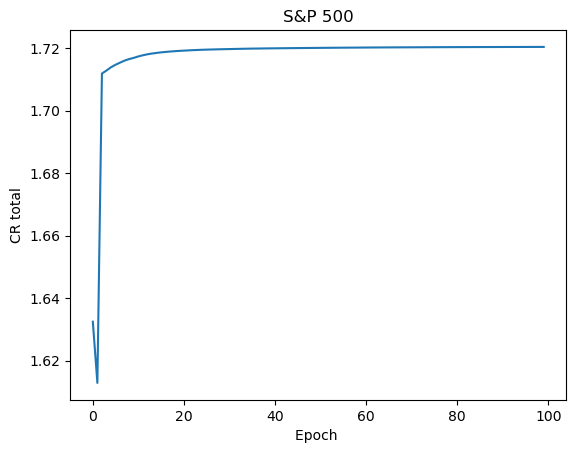

Rendement cumulé total pour le S&P 500 avec le  dataset de test 0.9128982197071261


In [33]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_spx, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

test_spx=test(x_test,theta_spx,delta,mu)
print("Rendement cumulé total pour le S&P 500 avec le  dataset de test {0}".format(test_spx))

*CAC 40*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\268400174.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


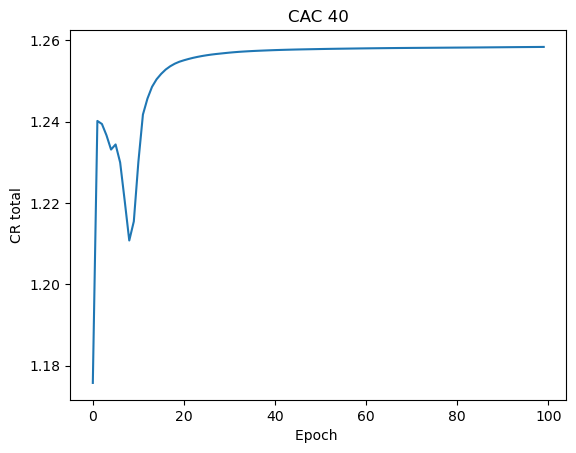

Rendement cumulé total pour le CAC 40 avec le  dataset de test 0.27443706203897744


In [34]:
x = np.array(cac_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_cac, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()

test_cac=test(x_test,theta_cac,delta,mu)
print("Rendement cumulé total pour le CAC 40 avec le  dataset de test {0}".format(test_cac))

*Nasdaq composite*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\871458553.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


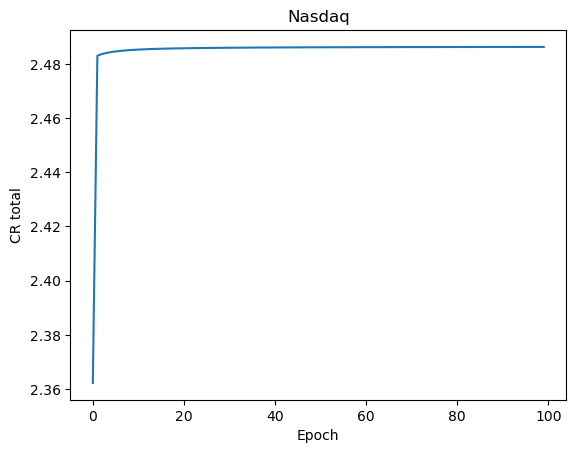

Rendement cumulé total pour le nasdaq avec le  dataset de test 1.3547178502951576


In [35]:
x = np.array(nasdaq_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_nasdaq, CRT_ = train(x_train,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

test_nasdaq=test(x_test,theta_nasdaq,delta,mu)
print("Rendement cumulé total pour le nasdaq avec le  dataset de test {0}".format(test_nasdaq))

*Dow Jones*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\2350613405.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


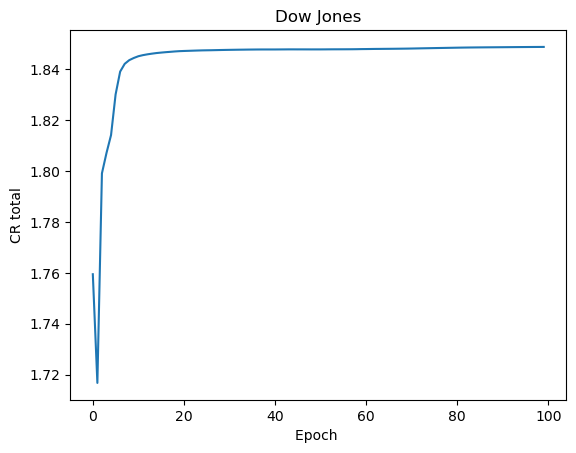

Rendement cumulé total pour le  Dow Jones avec le  dataset de test 0.7915619622872301


In [36]:
x = np.array(dj_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_dj, CRT_ = train(x_train,theta_coeff=1,drawdown=False,epochs=100, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

test_dj=test(x_test,theta_dj,delta,mu)
print("Rendement cumulé total pour le  Dow Jones avec le  dataset de test {0}".format(test_dj))

**Avec gestion du drawdown**

*S&P 500*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\27437146.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


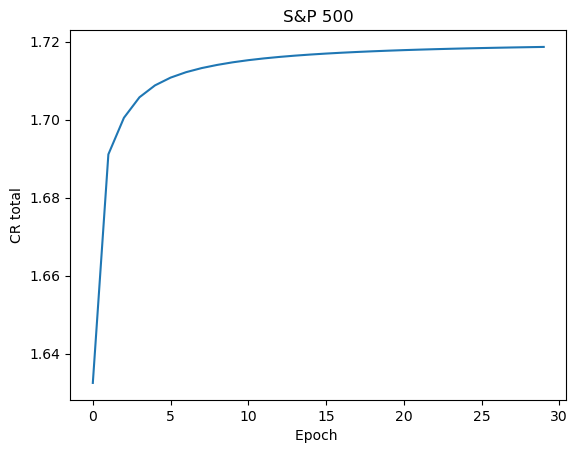

In [40]:
x = np.array(spx_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_spx, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

In [43]:
test_spx=test(x_test,theta_spx,delta,mu)
print("Le total de rendement cumulé pour le S&P 500 en mode test est : {0}".format(test_spx))

Le total de rendement cumulé pour le S&P 500 en mode test est : 0.9120431670310731


*CAC 40*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\3082075934.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


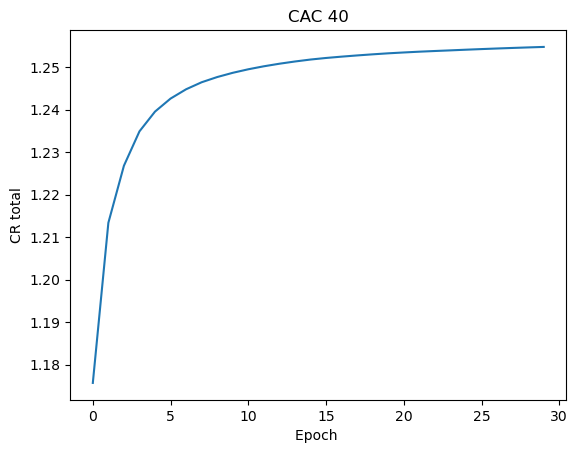

Rendement cumulé total pour le CAC 40 avec le  dataset de test 0.27336204155002763


In [45]:
x = np.array(cac_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_cac, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)
plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()

test_cac=test(x_test,theta_cac,delta,mu)
print("Rendement cumulé total pour le CAC 40 avec le  dataset de test {0}".format(test_cac))

*Nasdaq composite*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\3375422967.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


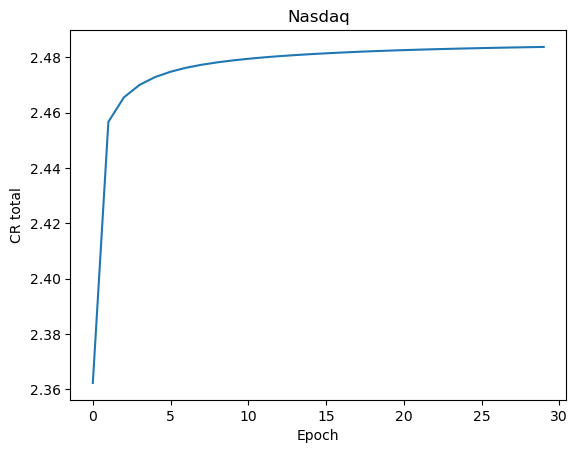

Rendement cumulé total pour le nasdaq avec le  dataset de test 1.3533029898996538


In [46]:
x = np.array(nasdaq_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_nasdaq, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)
plt.plot(CRT_)
plt.xlabel('Epoch')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

test_nasdaq=test(x_test,theta_nasdaq,delta,mu)
print("Rendement cumulé total pour le nasdaq avec le  dataset de test {0}".format(test_nasdaq))

*Dow Jones*

C:\Users\alpho\AppData\Local\Temp\ipykernel_23760\2819659303.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_train = np.int(len(x)*0.7)


finished training


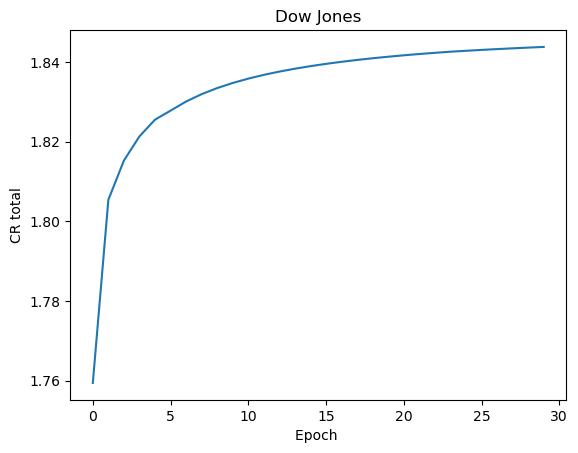

Rendement cumulé total pour le  Dow Jones avec le  dataset de test 0.7896099801873914


In [47]:
x = np.array(dj_r)
n_train = np.int(len(x)*0.7)
x_train=x[0:n_train]
x_test=x[n_train:]

theta_dj, CRT_ = train(x_train,drawdown=True,epochs=30, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

test_dj=test(x_test,theta_dj,delta,mu)
print("Rendement cumulé total pour le  Dow Jones avec le  dataset de test {0}".format(test_dj))

**Comparaisons**

In [48]:
def get_price(security, start_date, end_date, freq):
    return yf.download(tickers = security, start = start_date, end = end_date, interval = freq)['Adj Close']

In [51]:
train_debut='2015-12-31'
debut_test='2019-01-01'
fin_test='2020-01-01'

spx_train=get_price(security="^GSPC",start_date=None, end_date=train_debut, freq='1D')
spx_test=get_price(security="^GSPC",start_date=debut_test, end_date=fin_test, freq='1D')

cac_train=get_price(security="^FCHI",start_date=None, end_date=train_debut, freq='1D')
cac_test=get_price(security="^FCHI",start_date=debut_test, end_date=fin_test, freq='1D')

dj_train=get_price(security="^DJI",start_date=None, end_date=train_debut, freq='1D')
dj_test=get_price(security="^DJI",start_date=debut_test, end_date=fin_test, freq='1D')

nasdaq_train=get_price(security="^IXIC",start_date=None, end_date=train_debut, freq='1D')
nasdaq_test=get_price(security="^IXIC",start_date=debut_test, end_date=fin_test, freq='1D')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [52]:
spx_r_train=spx_train[1:] / spx_train[:-1].values- 1
spx_r_test=spx_test[1:] / spx_test[:-1].values- 1

cac_r_train=cac_train[1:] / cac_train[:-1].values- 1
cac_r_test=cac_test[1:] / cac_test[:-1].values- 1

dj_r_train=dj_train[1:] / dj_train[:-1].values- 1
dj_r_test=dj_test[1:] / dj_test[:-1].values- 1

nasdaq_r_train=nasdaq_train[1:] / nasdaq_train[:-1].values- 1
nasdaq_r_test=nasdaq_test[1:] / nasdaq_test[:-1].values- 1

In [53]:
theta_spx, CRT_ = train(spx_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


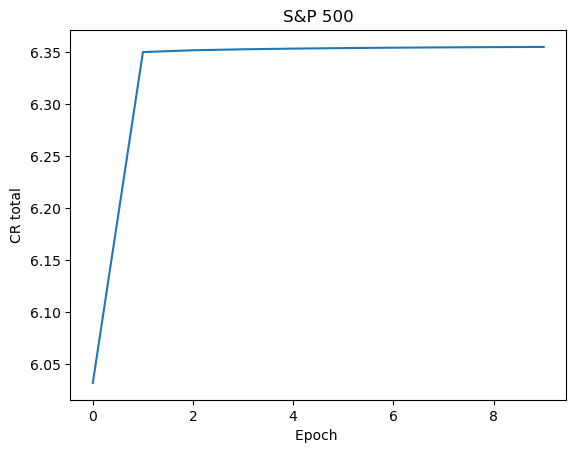

Rendement cumulé S&P 500 avec dataset 0.22554713224780965


In [54]:
plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("S&P 500")
plt.show()

test_spx=test(spx_r_test,theta_spx,delta,mu)
print("Rendement cumulé S&P 500 avec dataset {0}".format(test_spx))

In [55]:
theta_cac, CRT_ = train(cac_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

finished training


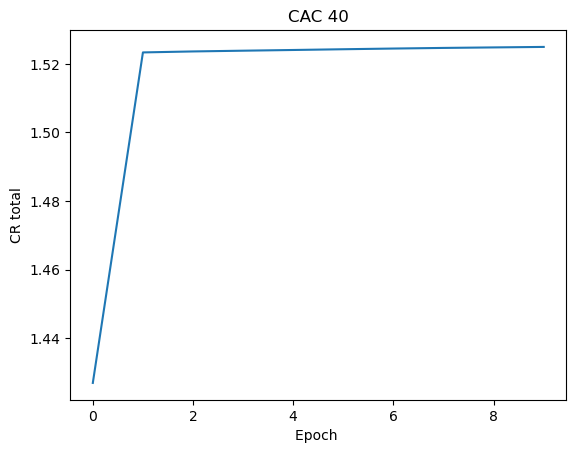

 Rendement cumulé Total CAC 40 avec le dataset 0.23014867974426348


In [56]:
plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("CAC 40")
plt.show()


test_cac=test(cac_r_test,theta_cac,delta,mu)
print(" Rendement cumulé Total CAC 40 avec le dataset {0}".format(test_cac))

finished training


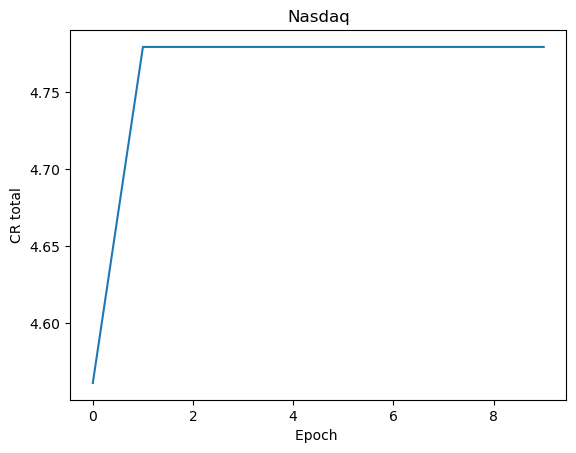

rendement cumulé nasdaq composite pour le dataset 0.2676196469789921


In [57]:
theta_nasdaq, CRT_ = train(nasdaq_r_train,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title("Nasdaq")
plt.show()

test_nasdaq=test(nasdaq_r_test,theta_nasdaq,delta,mu)
print("rendement cumulé nasdaq composite pour le dataset {0}".format(test_nasdaq))

finished training


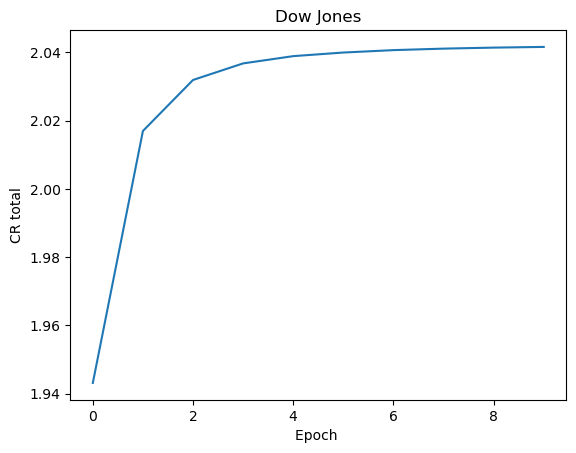

In [58]:
theta_dj, CRT_ = train(dj_r_train,theta_coeff=1,drawdown=False,epochs=10, M=xpast, learning_rate=learning_rate,delta=delta, mu=mu, eta=eta)

plt.plot(CRT_)
plt.xlabel('Epoch ')
plt.ylabel('CR total')
plt.title('Dow Jones')
plt.show()

In [59]:
test_dj=test(dj_r_test,theta_dj,delta,mu)
print("rendement cumulé total Dow Jones avec le dataset {0}".format(test_dj))

rendement cumulé total Dow Jones avec le dataset 0.17824360880603826


*Fonctions d'evaluations*

In [78]:
def get_price(x, theta, mu):
  F, Fpos = positions(x, theta)
  T = len(x)
  ret = F * x
  cumret = (1 + np.array(ret)).cumprod() - 1
  price = mu*(1+cumret)
  return price

def return_annualized(price):
  ret = pd.DataFrame(price).pct_change()[1:]
  return np.mean(ret)*252

def vol_annualized(price):
  ret = pd.DataFrame(price).pct_change()[1:]
  return np.std(ret)*np.sqrt(252)

def sharpe_ratio(r,vol):
    return r/vol

def get_ratios(price):
    R=return_annualized(price)[0]
    vol_=vol_annualized(price)[0]
    sharpe_=sharpe_ratio(R,vol_)  
    return R,vol_,sharpe_

def plot_graphique(benchmark, portfolio, date_portfolio):
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(' Benchmark VS prix de notre portefeuille', fontsize = 20)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Dates')
    ax.set_ylabel('Price')
    ax.plot(benchmark.index, benchmark, label='Benchmark') 
    ax.plot(date_portfolio, portfolio, label=' RRL')
    ax.legend()
    plt.show()
  

def print_ratio(benchmark, portfolio):
  return_bench, vol_bench, sharpe_bench = get_ratios(benchmark)
  return_port, vol_port, sharpe_port = get_ratios(portfolio)
  result = pd.DataFrame(data = [[return_bench, return_port], 
                              [vol_bench, vol_port],
                              [sharpe_bench, sharpe_port]],
                     columns = ['Benchmark', 'portefeuille'],
                     index = ['Retours annualisés', 'Volatilité annualisés', 'Sharpe Ratio'])
  return result

def long_short_pos(x, theta):
    F,Fpos = positions(x, theta)
    pos=F[1:]-F[:-1]
    return np.sign(pos)


*S&P 500*

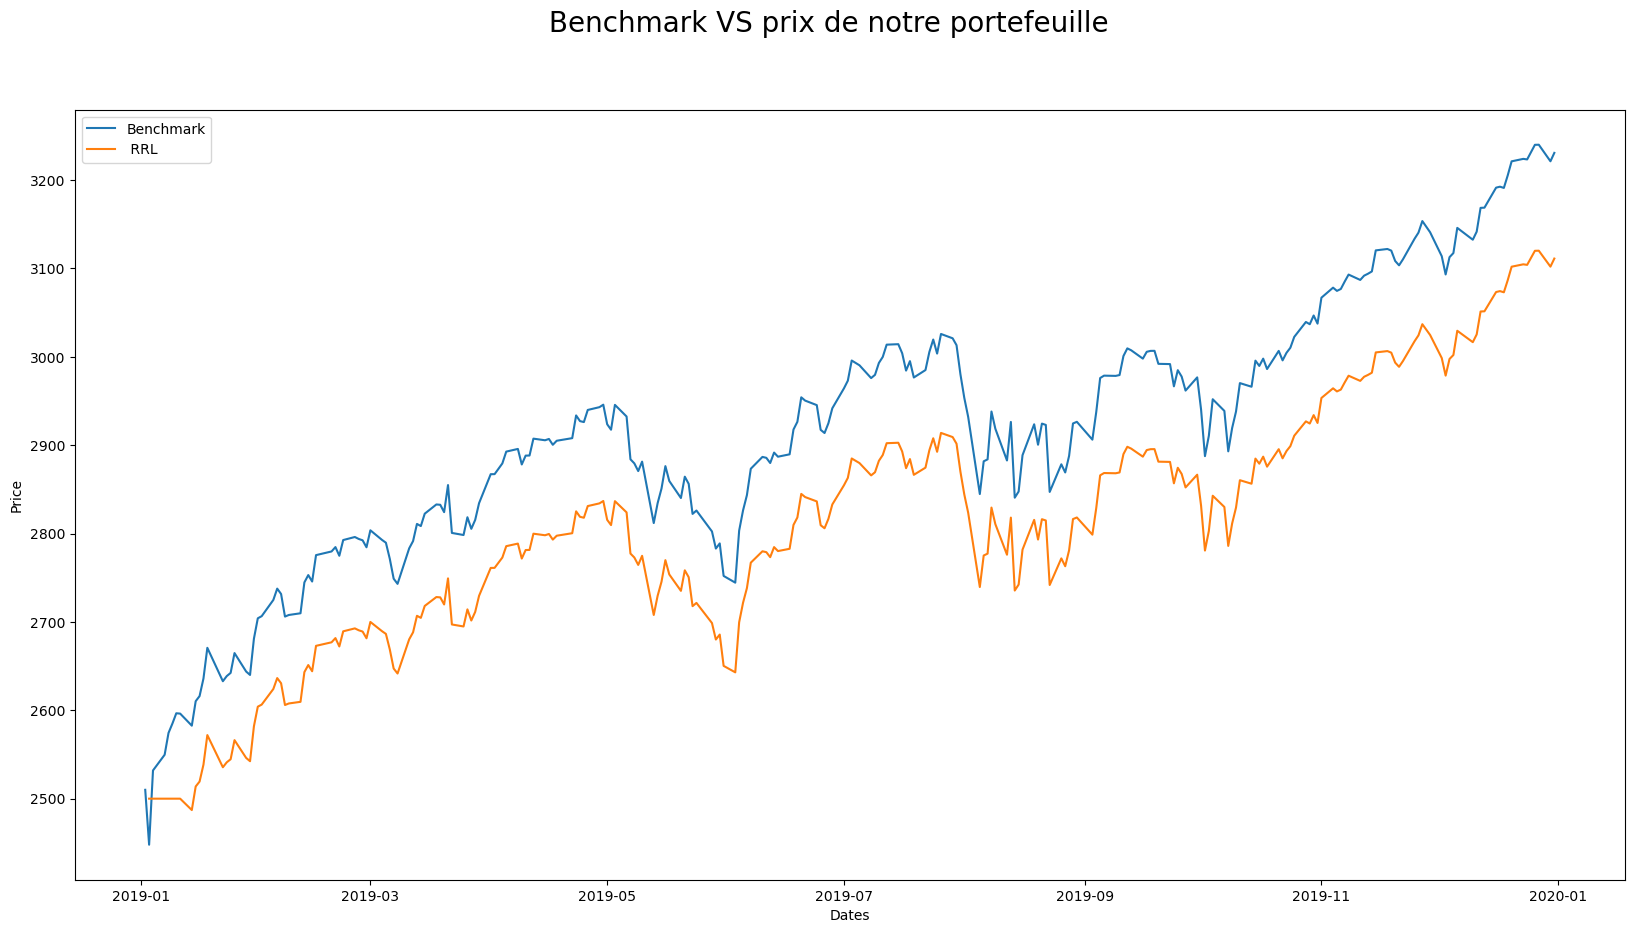

c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


                       Benchmark  portefeuille
Retours annualisés      0.261357      0.227431
Volatilité annualisés   0.124720      0.117001
Sharpe Ratio            2.095539      1.943844


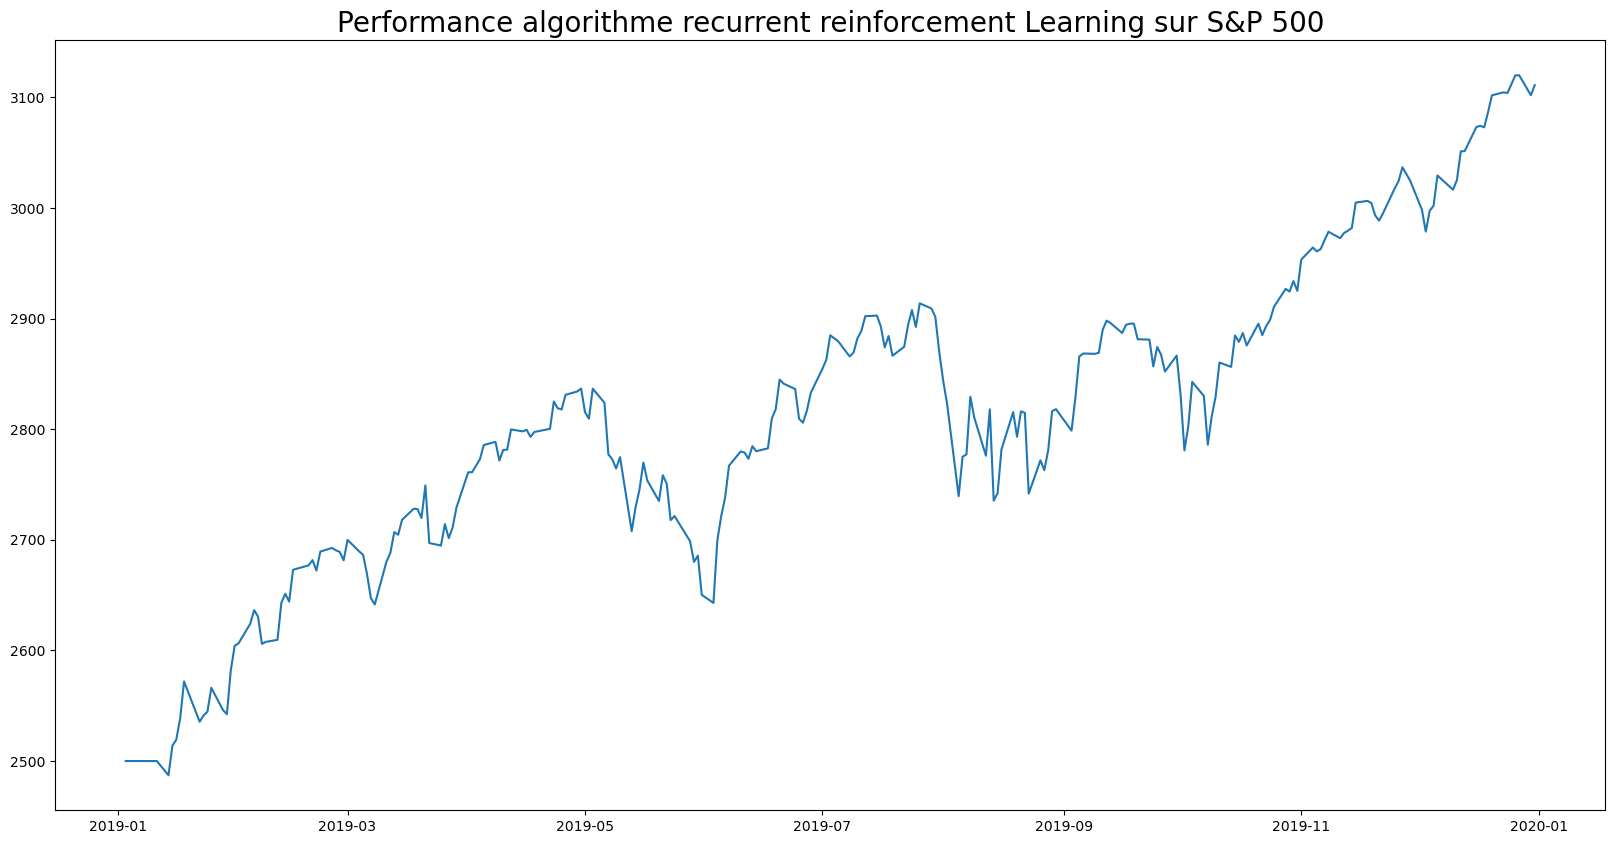

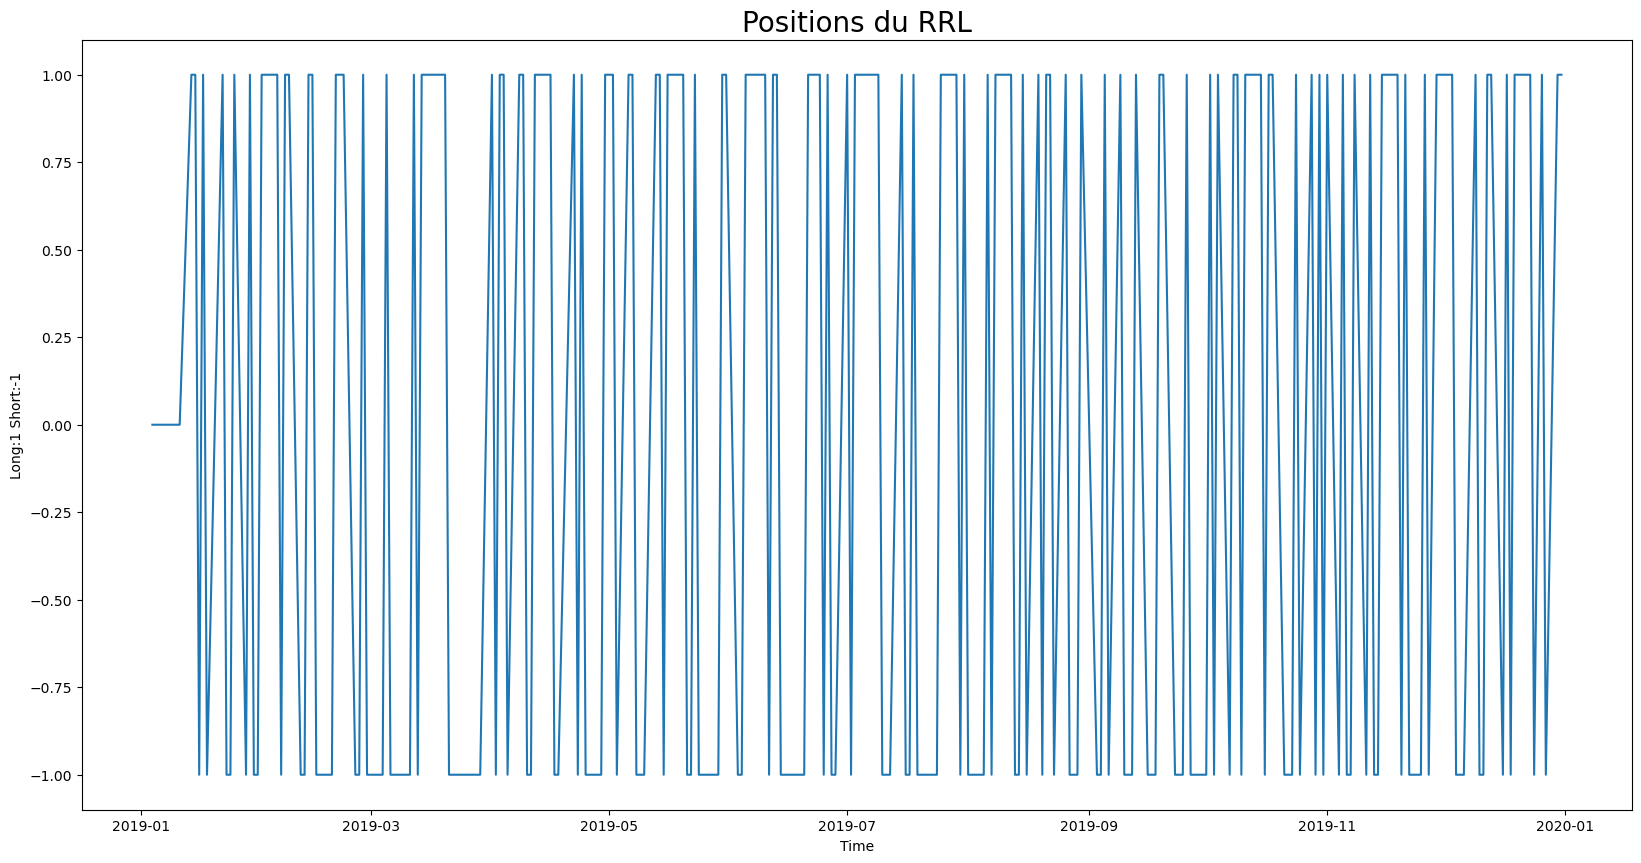

In [91]:
price_p_spx = get_price(spx_r_test, theta_spx, 2500)
plot_graphique(spx_test, price_p_spx, spx_r_test.index)

plt.figure(figsize=(20,10))
plt.plot(spx_r_test.index, price_p_spx)
plt.title("Performance algorithme recurrent reinforcement Learning sur S&P 500", fontsize = 20)

result_spx = print_ratio(spx_test, price_p_spx)
print(result_spx)

pos_spx=long_short_pos(spx_r_test,theta_spx)

plt.figure(figsize=(20,10))
plt.plot(spx_r_test.index[1:], pos_spx)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Positions du RRL', fontsize = 20)
plt.show()

*CAC 40*

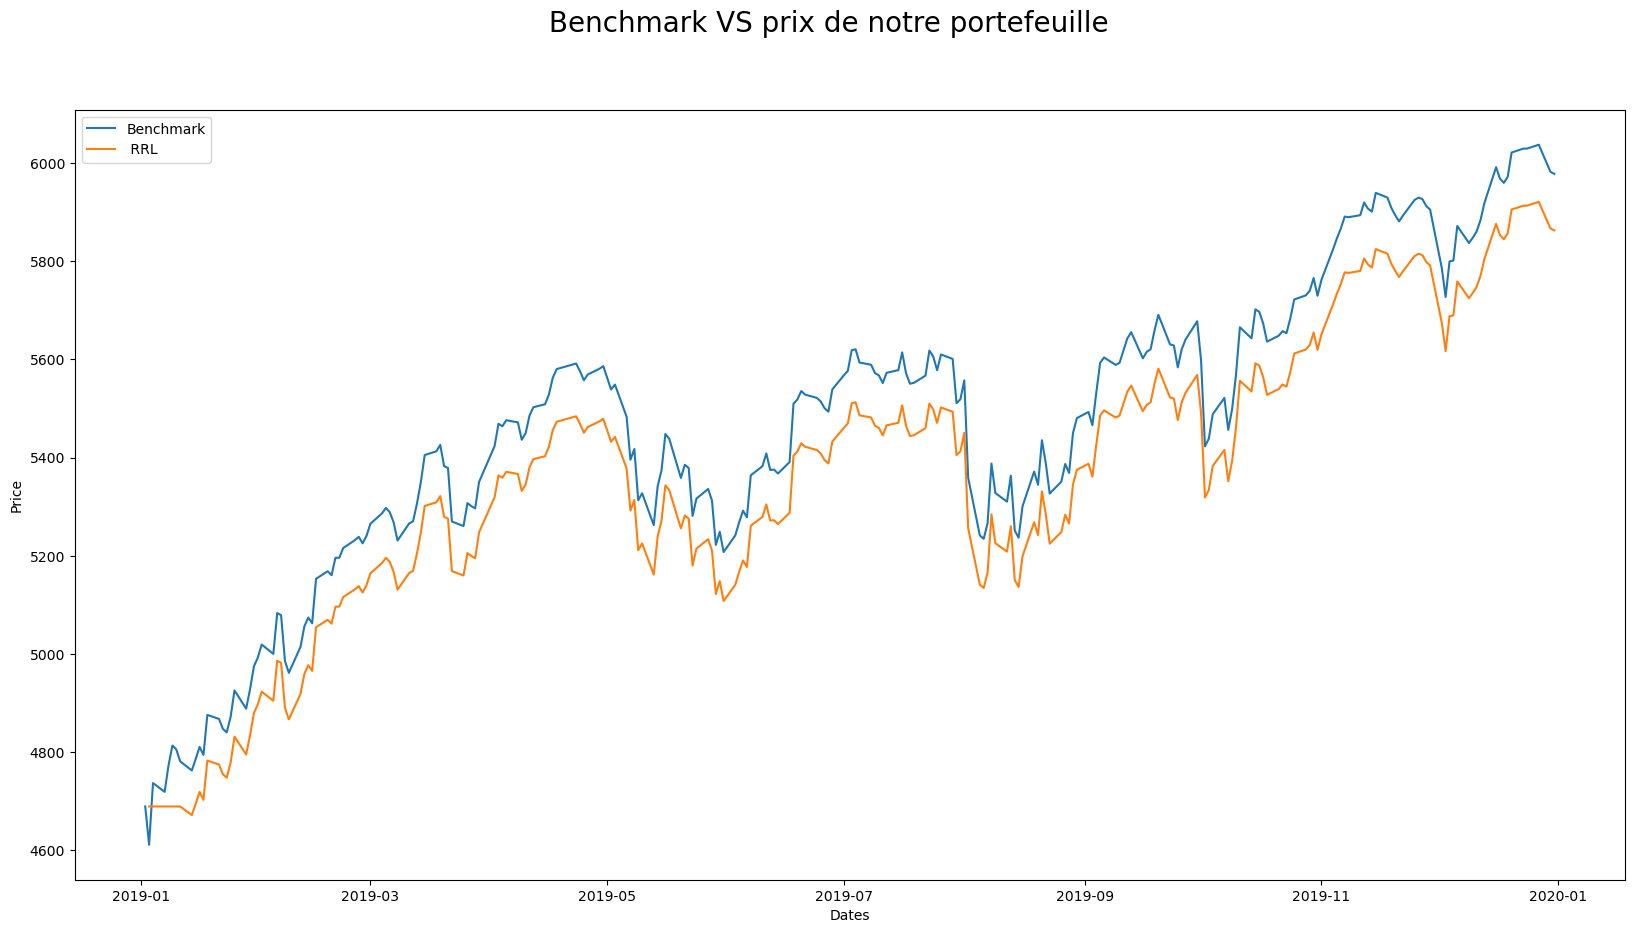

c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


                       Benchmark  portefeuille
Retours annualisés      0.249766      0.230721
Volatilité annualisés   0.132235      0.127674
Sharpe Ratio            1.888803      1.807117


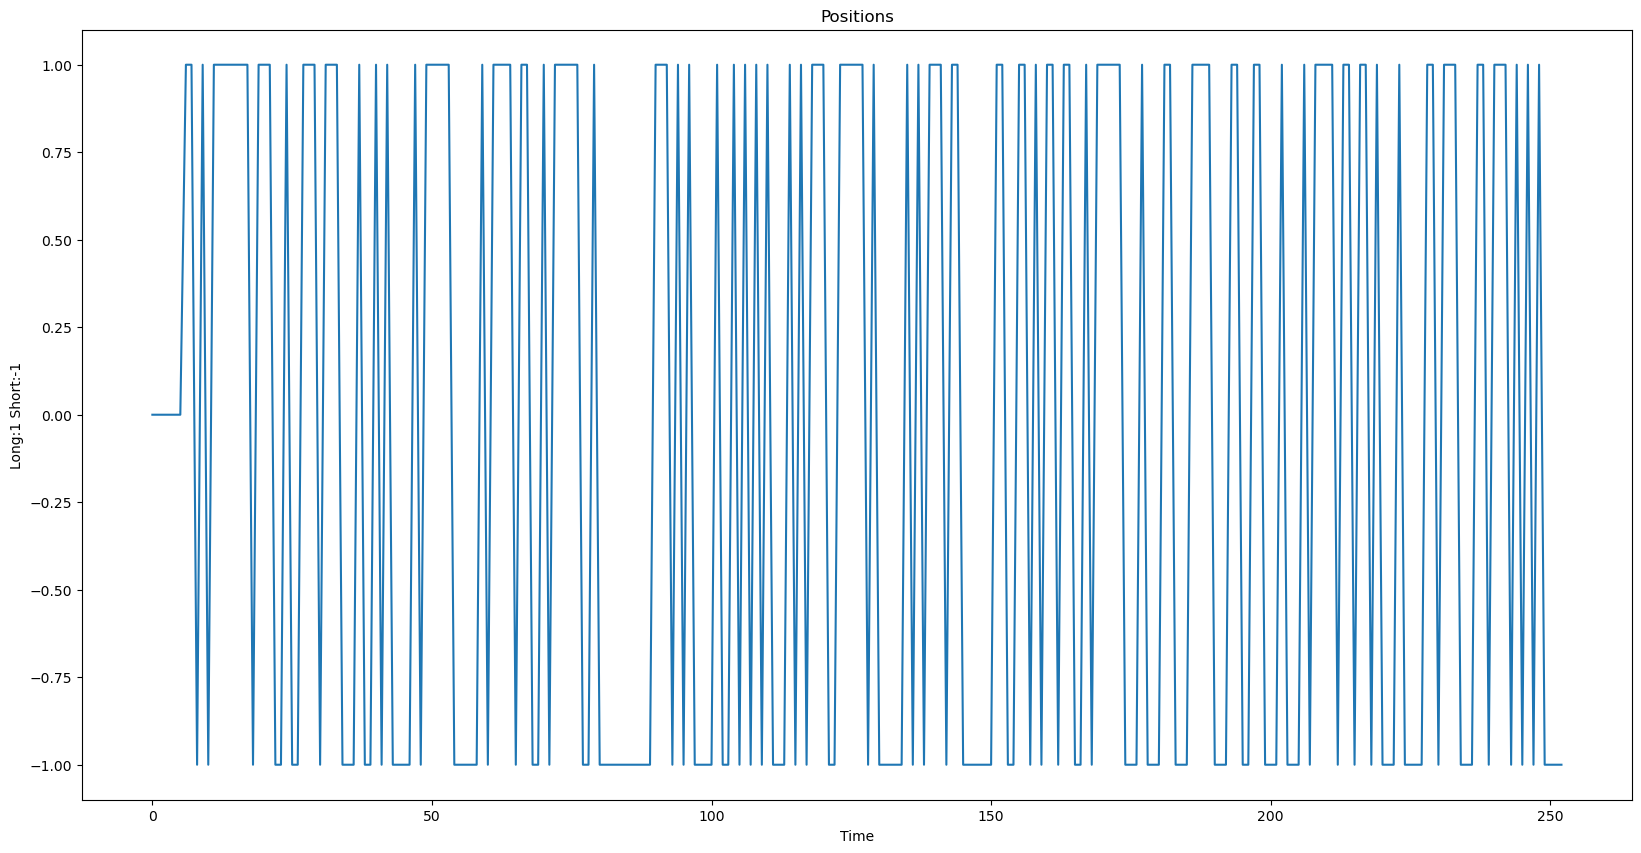

In [88]:
price_p_cac = get_price(cac_r_test, theta_cac, cac_test[0])
plot_graphique(cac_test, price_p_cac, cac_r_test.index)

result_cac = print_ratio(cac_test, price_p_cac)
print(result_cac)

pos_cac=long_short_pos(cac_r_test,theta_cac)

plt.figure(figsize=(20,10))
plt.plot(pos_cac)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Positions')
plt.show()


*Nasdaq composite*

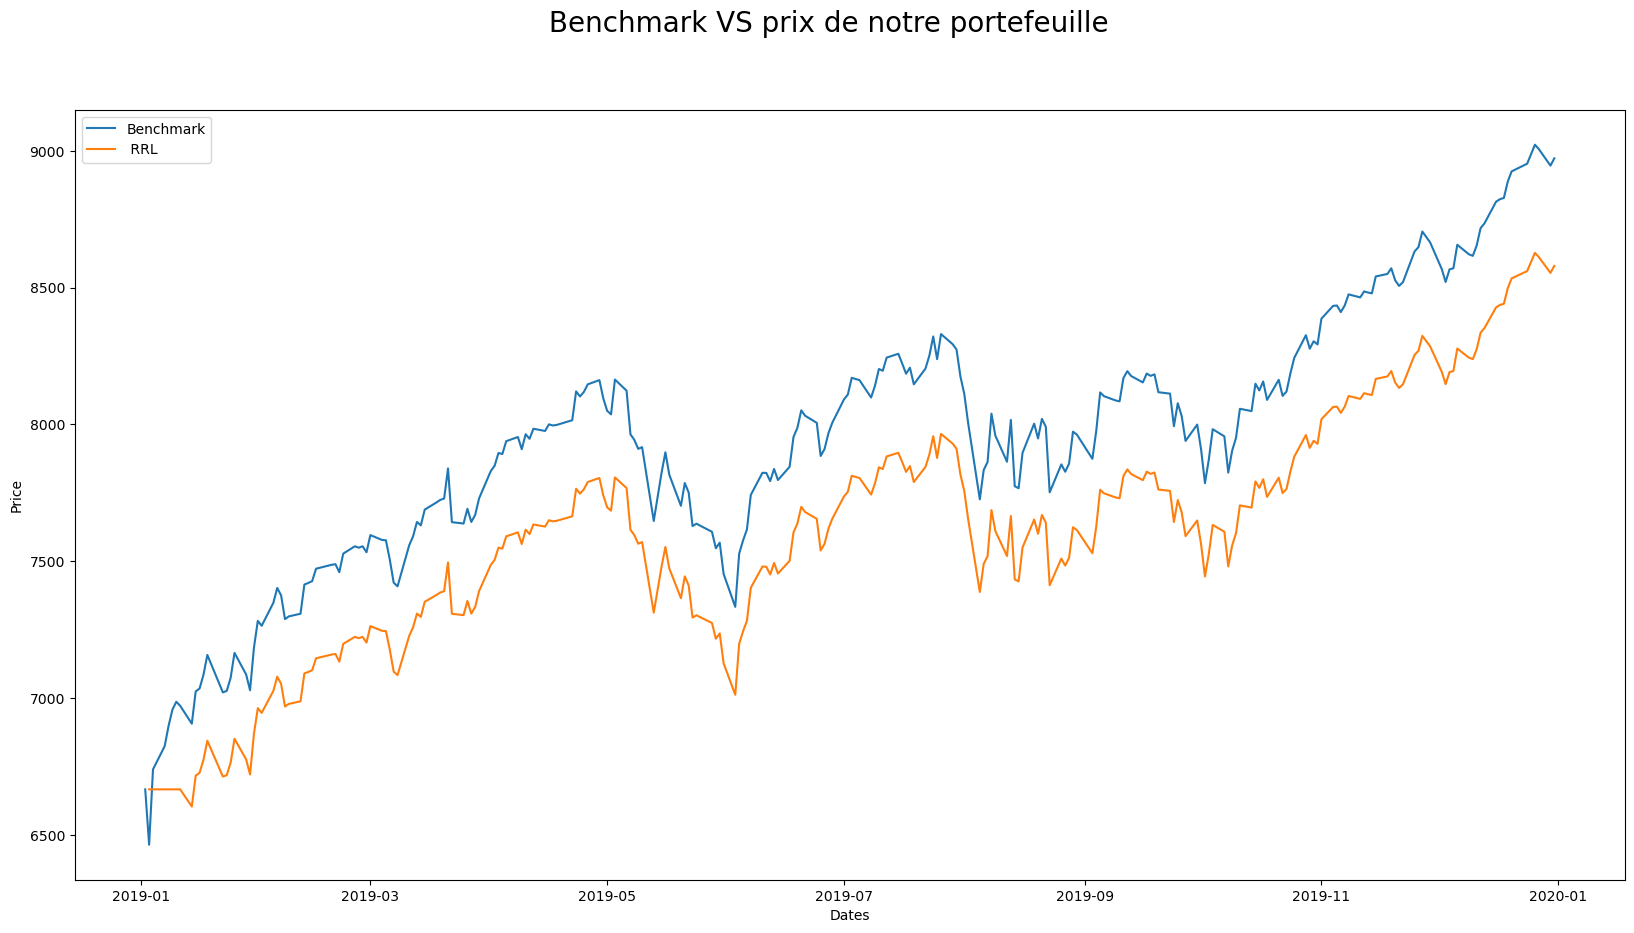

c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


                       Benchmark  portefeuille
Retours annualisés      0.310805      0.265324
Volatilité annualisés   0.156566      0.146911
Sharpe Ratio            1.985136      1.806013


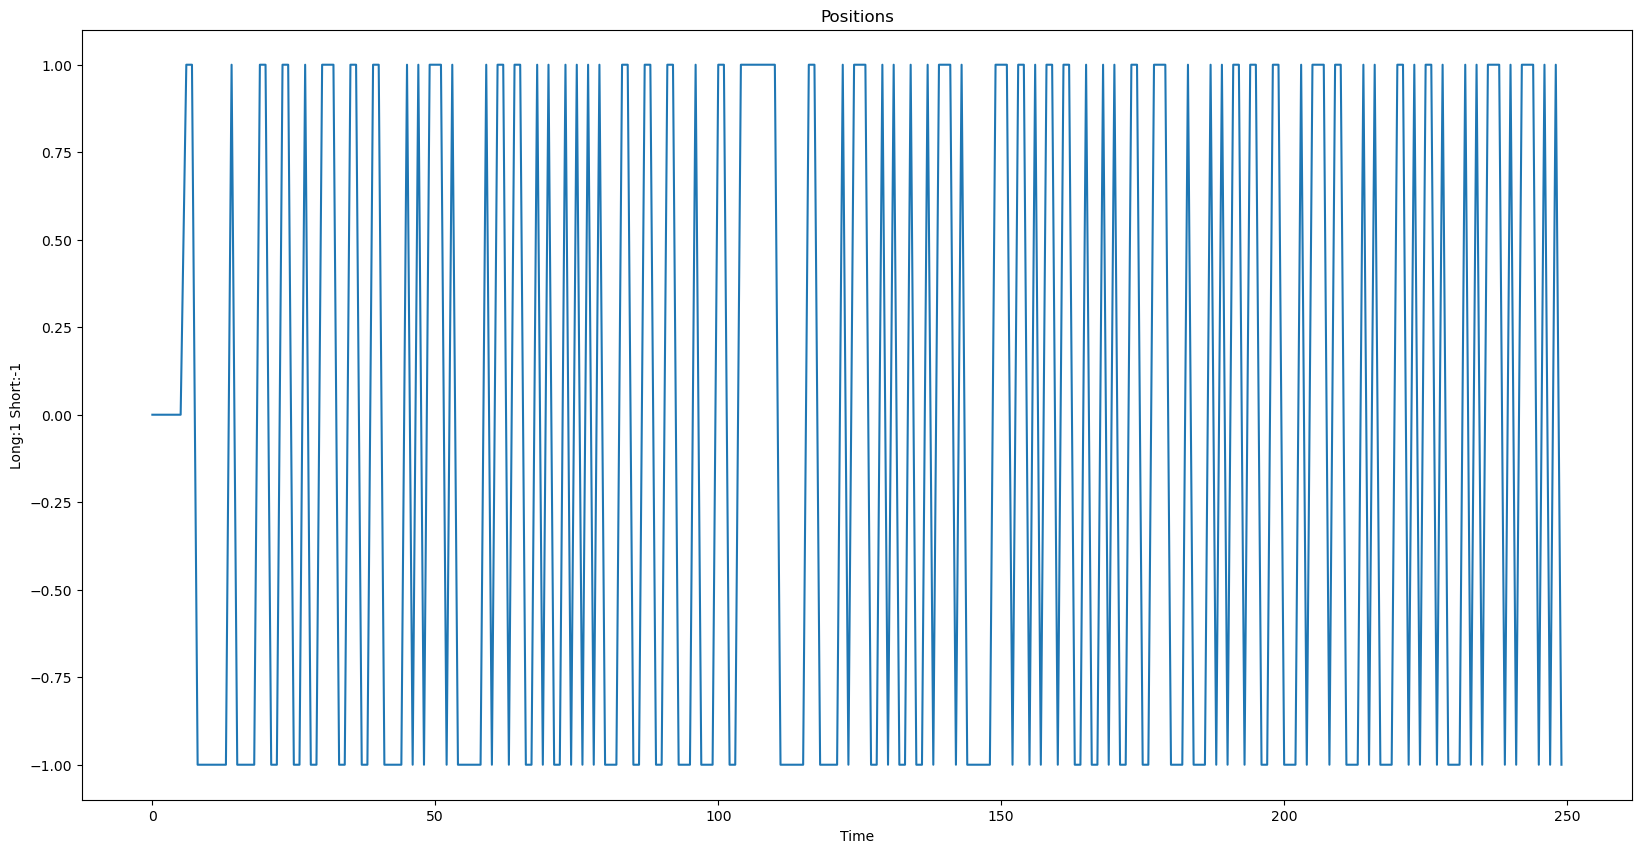

In [89]:
price_p_nasdaq = get_price(nasdaq_r_test, theta_nasdaq, nasdaq_test[0])

plot_graphique(nasdaq_test, price_p_nasdaq, nasdaq_r_test.index)

result_nasdaq = print_ratio(nasdaq_test, price_p_nasdaq)
print(result_nasdaq)

pos_nasdaq=long_short_pos(nasdaq_r_test,theta_nasdaq)

plt.figure(figsize=(20,10))
plt.plot(pos_nasdaq)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Positions')
plt.show()

*Dow Jones*

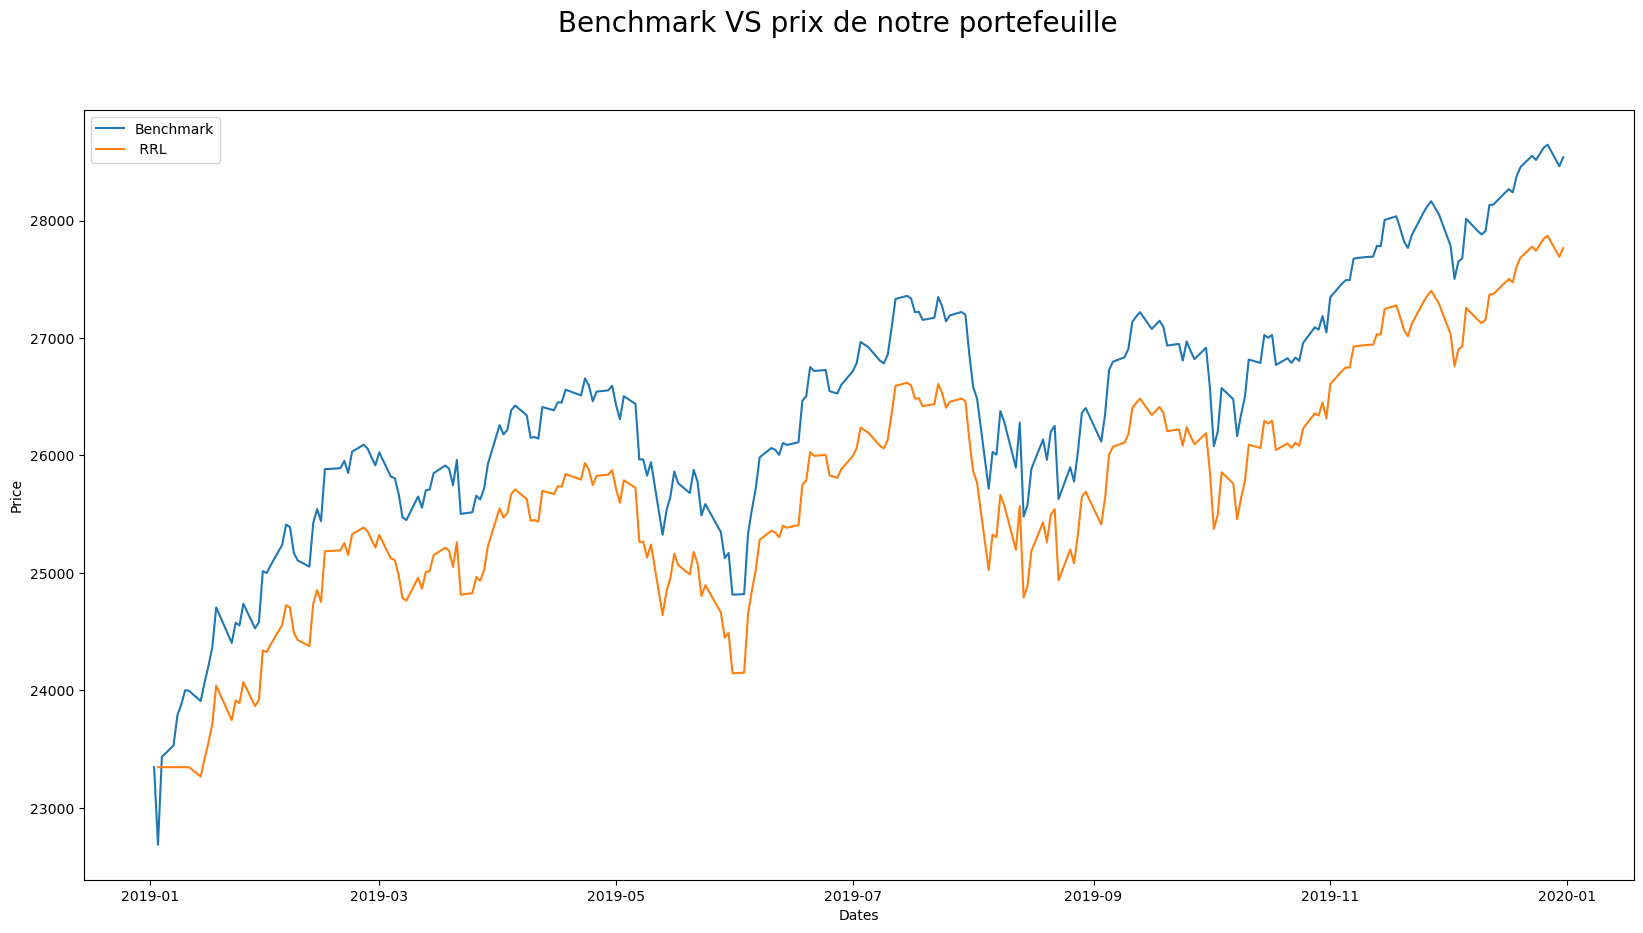

c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\alpho\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


                       Benchmark  portefeuille
Retours annualisés      0.209449      0.181548
Volatilité annualisés   0.124363      0.116037
Sharpe Ratio            1.684174      1.564575


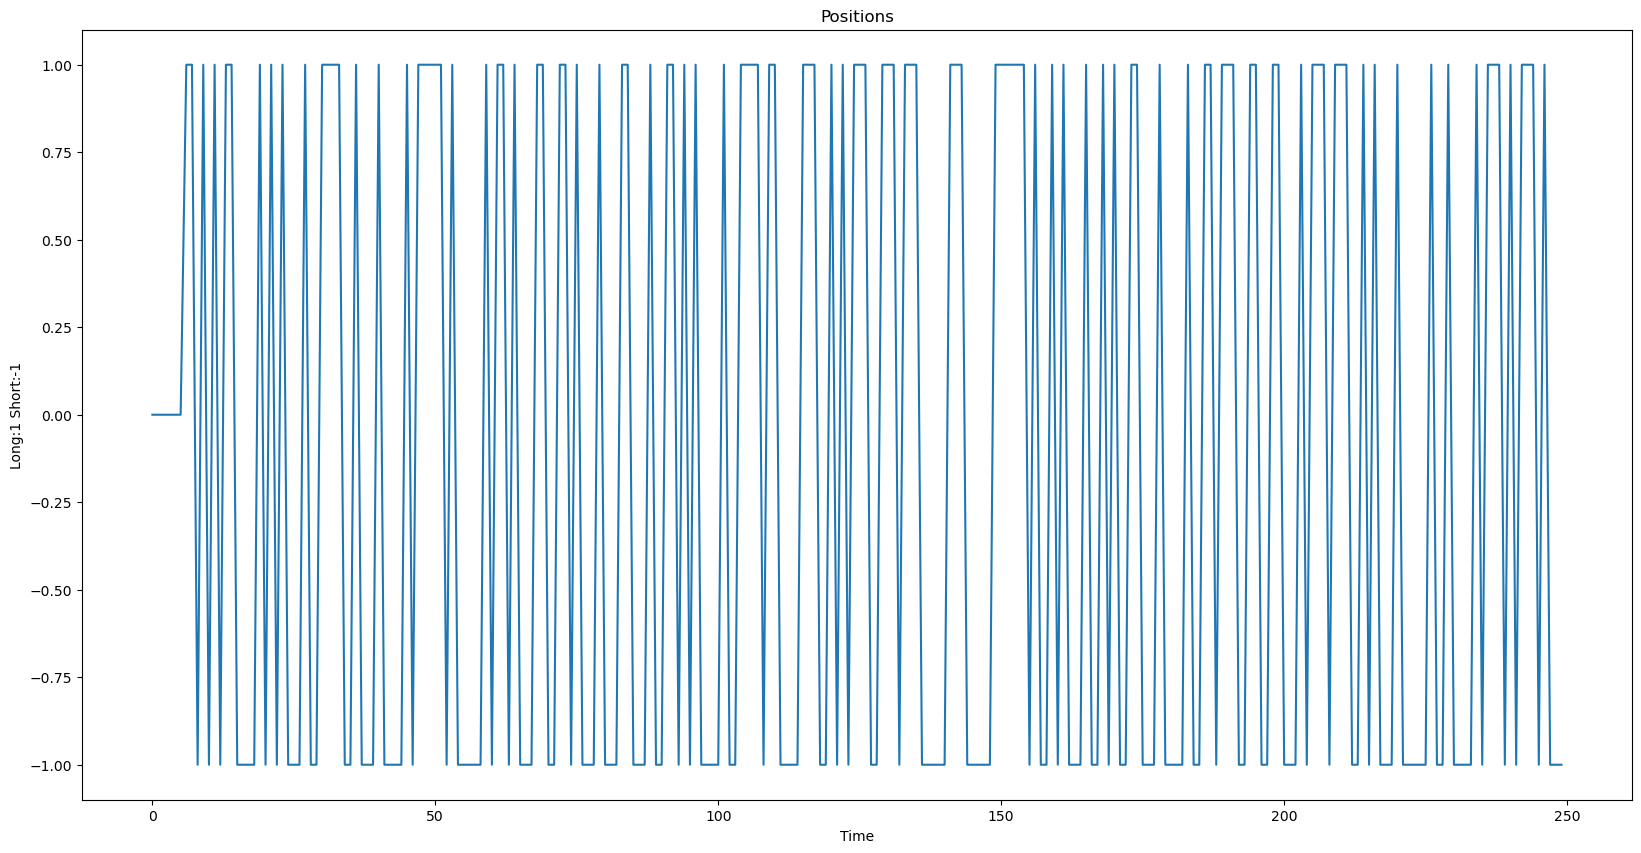

In [90]:
price_p_dj = get_price(dj_r_test, theta_dj, dj_test[0])

plot_graphique(dj_test, price_p_dj, dj_r_test.index)

result_dj = print_ratio(dj_test, price_p_dj)
print(result_dj)

pos_dj=long_short_pos(dj_r_test,theta_dj)

plt.figure(figsize=(20,10))
plt.plot(pos_dj)
plt.xlabel('Time')
plt.ylabel("Long:1 Short:-1")
plt.title('Positions')
plt.show()